In [1]:
from helpers import *
from structure import UmbrellaGrid

In [27]:
degree = 3
rows = 3
cols = 10
#---
grid = UmbrellaGrid(degree, rows, cols)

In [28]:
border_cells = grid.border_cells()
center_cells = grid.center_cells()
active_cells    = border_cells+center_cells
target_percents = [0]*len(border_cells) + [100]*len(center_cells) # 0 -> colse | 100 -> open
#---
active_cells    = [0, 1]
target_percents = [0, 100]

In [29]:
grid.generate_mesh('test_01')

PLATE CHARACTERISTIQUES:
	plate thickness   : 0.009203, 0.009202670470725129
	plate edge length : 0.092027


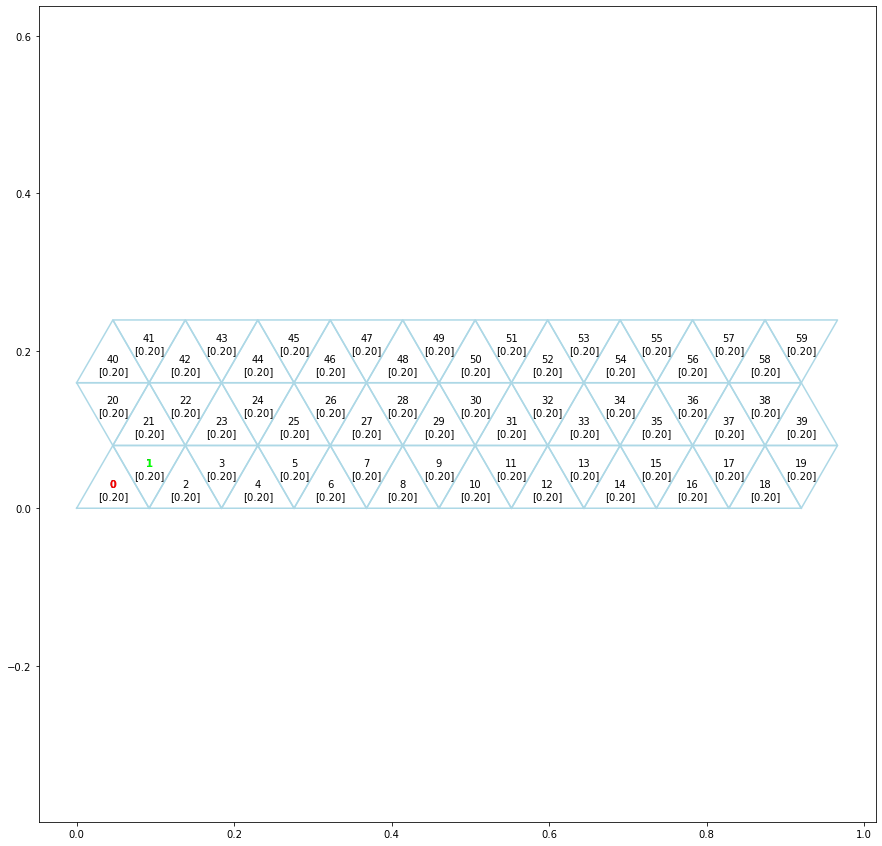

In [30]:
plot2D(grid.input_data, grid.curr_um, True, active_cells=active_cells, target_percents=target_percents)

In [31]:
view3D = plot3D(grid.curr_um, grid.input_data)
view3D.show()
# view3D.save('filename') # save as object (obj) file

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

In [32]:
grid.deploy(active_cells, target_percents, view3D)

success :  True 

energies:
('Full', -1.9999694523033773)
('Elastic', 3.0245899924293274e-05)
('Deployment', -1.9999996982033017)
('Repulsion', 0.0)
('Attraction', 0.0)
('AngleBoundPenalty', 0.0)


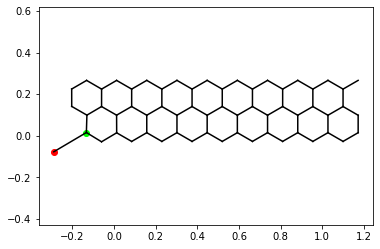

In [33]:
projection2D(grid.input_data, grid.curr_um, active_cells=active_cells, target_percents=target_percents)

In [34]:
sview_vm = plot_stress3D(grid.curr_um, 'maxBending')
sview_vm.show()

maxBending Stresses Extrem values:
    max : 1.56e+02
    min : 0.00e+00


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

In [35]:
plot_stress2D(grid, 'maxBending')

TypeError: 'float' object is not iterable

In [81]:
def _get_stresses(curr_um, stress_type):
    if stress_type=='Von Mises':
        stresses = curr_um.maxVonMisesStresses()
    elif stress_type=='maxBending':
        stresses = curr_um.maxBendingStresses()
    elif stress_type=='minBending':
        stresses = curr_um.minBendingStresses()
    elif stress_type=='Twisting':
        stresses = curr_um.twistingStresses()
    elif stress_type=='Stretching':
        stresses = curr_um.stretchingStresses()
    else:
        raise ValueError(f'the required stress type <{stress_type}> do not correspond to any available stress')
    return stresses

def _get_stress_matrix(grid, stress_type='maxBending'):
    matrix = np.zeros((grid.numUmbrellas, grid.numUmbrellas)) # 2 x 11 : segment x rod? | numUmbrellas might be degree -> to optimize
    stress_all = _get_stresses(grid.curr_um, stress_type)
    for seg_id in range(grid.curr_um.numSegments()):
        seg = grid.curr_um.segment(seg_id)
        if seg.segmentType()==umbrella_mesh.SegmentType.Arm:
            sjoint = seg.startJoint
            ejoint = seg.endJoint
            stresses = stress_all[seg_id]
            if grid.curr_um.joint(sjoint).jointPosType()==umbrella_mesh.JointPosType.Arm:
                i,j = grid.curr_um.joint(ejoint).umbrellaID()
            if grid.curr_um.joint(ejoint).jointPosType()==umbrella_mesh.JointPosType.Arm:
                i,j = grid.curr_um.joint(sjoint).umbrellaID()
            matrix[i,j] = matrix[j,i] = max(matrix[i,j], max(stresses))
    return matrix

def plot_stress2D(grid, stress_type='maxBending'):
    center_positions = _get_center_position(grid.curr_um)
    matrix = _get_stress_matrix(grid, stress_type)
    max_, min_ = matrix.max(), matrix.min()
    color = []
    for i,j in grid.input_data['umbrella_connectivity']:
        if max_ != min_:
            r = (matrix[i,j]-min_)/(max_-min_)
            g = 0.1
            b = 1-r
        else: r,g,b = 0,0,0
        x = center_positions[[i,j],0]
        y = center_positions[[i,j],1]
        plt.plot(y, x, c=(r,g,b))
    plt.axis('equal')
    plt.show()
        # clean_top.append(matrix[i,j].tolist())
        # clean_bot.append(matrix[j,i].tolist())
    # for i,arm in enumerate(clean_top):
    #     x = []
    #     for seg in arm:
    #         x += seg[1:-1]
    #     y = np.linspace(i,i+1, len(x))
    #     plt.plot(y,x)
def projection2D(input_data, curr_um, active_cells=[], target_percents=[]):
    center_position = _get_center_position(curr_um)
    vertices = input_data['umbrella_connectivity']
    center_xy = np.array(list(zip(center_position[:,0], center_position[:,1])))
    segments = center_xy[vertices]
    
    for s in segments:
        plt.plot(s[:,0], s[:,1], c='black')
    
    # color for actve_cell
    if active_cells != []:
        for i, p in zip(active_cells, target_percents):
            g = p/100
            r = 1-g
            b = 0
            [x,y,_] = center_position[i]
            plt.scatter(x,y, color=(r,g,b))
            
    plt.axis('equal')
    plt.show()

def _get_center_position(curr_um):
    nb_cell = curr_um.numUmbrellas()
    center_position = np.zeros([nb_cell, 3])
    for i in range(nb_cell):
        top_idx = curr_um.getUmbrellaCenterJi(i, 0)
        center_position[i] = curr_um.joint(top_idx).position
    return center_position

In [82]:
_get_stress_matrix(grid)

array([[0.00000000e+00, 1.55866166e+02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.55866166e+02, 0.00000000e+00, 8.97826786e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.97826786e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.30906877e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.30906877e-04, 0.00000000e+00, 1.10606568e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.10606568e-05, 0.00000000e+00]])

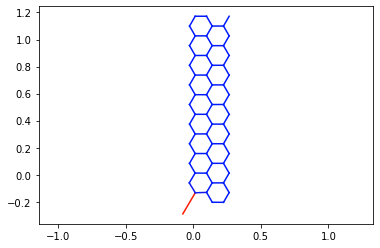

In [83]:
plot_stress2D(grid)

In [77]:
_get_center_position(grid.curr_um)[[0,1], 1], _get_center_position(grid.curr_um)

(array([-0.07687522,  0.01561575]),
 array([[-0.2898303 , -0.07687522,  0.00378689],
        [-0.13330941,  0.01561575,  0.09754165],
        [-0.060477  , -0.02885988,  0.09656582],
        [ 0.01220253,  0.01426243,  0.09708709],
        [ 0.08430616, -0.02721462,  0.09693907],
        [ 0.15677463,  0.01478217,  0.09697088],
        [ 0.22930688, -0.02706632,  0.09693637],
        [ 0.30181947,  0.01482683,  0.09695501],
        [ 0.37435131, -0.02704115,  0.09694621],
        [ 0.44687788,  0.01484088,  0.09695517],
        [ 0.51940845, -0.02703075,  0.09695278],
        [ 0.59193813,  0.01484827,  0.09695729],
        [ 0.66446858, -0.02702466,  0.0969564 ],
        [ 0.73699808,  0.01485283,  0.09695889],
        [ 0.80952859, -0.02702065,  0.09695838],
        [ 0.88205791,  0.01485623,  0.09696001],
        [ 0.95458852, -0.02701749,  0.09695962],
        [ 1.02711776,  0.01485913,  0.09696091],
        [ 1.09964845, -0.02701471,  0.09696054],
        [ 1.17217765,  0.01486182